# Testing Sinkhorn implementation

In [5]:
import numpy as np
import torch
from torch.nn import MSELoss
from geomloss import SamplesLoss
from matplotlib import pyplot as plt
%matplotlib inline

## Sinkhorn divergence of different batches on the data set

In [18]:
def calculate_sinkhorn(
    batchsize=1000,
    blur=0.05,
    filename="../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.001_x_train.npy", 
    tests=20
):
    x = np.load(filename)
    all_indices = np.arange(0, len(x), dtype=np.int)
    sinkhorn = SamplesLoss("sinkhorn", p=2, blur=blur, scaling=0.5, backend="auto")
    
    divs = []
    for _ in range(tests):
        x0 = torch.tensor(x[np.random.choice(all_indices, batchsize)])
        x1 = torch.tensor(x[np.random.choice(all_indices, batchsize)])
        div = sinkhorn(x0, x1).numpy()
        divs.append(div)
        
    return np.mean(divs), np.std(divs)

In [27]:
blurs = [0.001, 0.01, 0.05, 0.1, 1.]
batchsizes = [10, 30, 100, 300, 1000]

sinkhorn_means = []
sinkhorn_stds = []

for blur in blurs:
    for batchsize in batchsizes:
        print(blur, batchsize)
        mean, std = calculate_sinkhorn(batchsize, blur)
        sinkhorn_means.append(mean)
        sinkhorn_stds.append(std)
        
sinkhorn_means = np.array(sinkhorn_means).reshape(len(blurs), -1)
sinkhorn_stds = np.array(sinkhorn_stds).reshape(len(blurs), -1)

0.001 10
0.001 30
0.001 100
0.001 300
0.001 1000
0.01 10
0.01 30
0.01 100
0.01 300
0.01 1000
0.05 10
0.05 30
0.05 100
0.05 300
0.05 1000
0.1 10
0.1 30
0.1 100
0.1 300
0.1 1000
1.0 10
1.0 30
1.0 100
1.0 300
1.0 1000


In [44]:

sinkhorn_stds = np.array(sinkhorn_stds).reshape(len(blurs), -1)

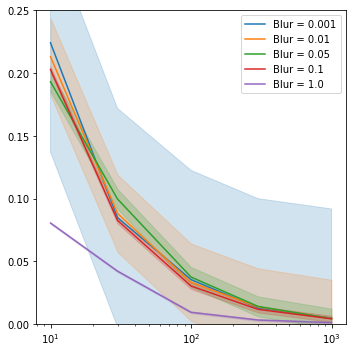

In [31]:
plt.figure(figsize=(5,5))

for i, (blur, means, stds) in enumerate(zip(blurs, sinkhorn_means, sinkhorn_stds)):
    plt.fill_between(batchsizes, means-stds, means+stds, color="C{}".format(i), alpha=0.2)
    plt.plot(batchsizes, means, ls="-", lw=1.5, color="C{}".format(i), label="Blur = {}".format(blur))
    
plt.legend()

plt.ylim(0., 0.25)
plt.xscale("log")

plt.tight_layout()
plt.show()


In [35]:
model_sinkhorn_bs1000.shape

(2, 40)

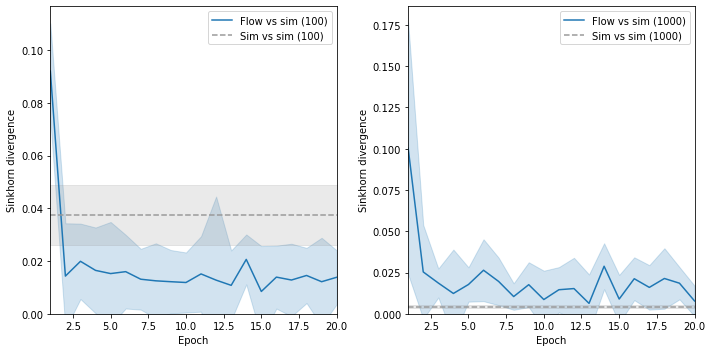

In [52]:
model_sinkhorn_bs100 = np.load(
    "../data/learning_curves/gamf_2_spherical_gaussian_2_3_0.001_debug.npy"
).reshape(2,20,2)[1,:,:] * 0.1
model_sinkhorn_bs1000 = np.load(
    "../data/learning_curves/gamf_2_spherical_gaussian_2_3_0.001_debug_largebs.npy"
).reshape(2,20,2)[1,:,:] * 0.1

fig = plt.figure(figsize=(10,5))

for i, (model_data, label) in enumerate(zip([model_sinkhorn_bs100, model_sinkhorn_bs1000], ["100", "1000"])):
    ax = plt.subplot(1,2,i+1)
    plt.fill_between(
        list(range(1,21)),
        model_data[:,0] - model_data[:,1], 
        model_data[:,0] + model_data[:,1],
        color="C0",
        alpha=0.2
    )
    plt.plot(
        list(range(1,21)),
        model_data[:,0],
        ls="-",
        lw=1.5,
        color="C0",
        label="Flow vs sim ({})".format(label)
    )
    
    k = 2 if i == 0 else 4
    plt.fill_between(
        [1, 21],
        [sinkhorn_means[2,k]-sinkhorn_stds[2,k], sinkhorn_means[2,k]-sinkhorn_stds[2,k]],
        [sinkhorn_means[2,k]+sinkhorn_stds[2,k], sinkhorn_means[2,k]+sinkhorn_stds[2,k]],
        color="0.6",
        alpha=0.2
    )
    plt.plot(
        [1, 21],
        [sinkhorn_means[2,k], sinkhorn_means[2,k]],
        c="0.6", ls="--", label="Sim vs sim ({})".format(label)
    )
        
    plt.legend()
    plt.xlim(1, 20)
    plt.ylim(0., None)
    
    plt.xlabel("Epoch")
    plt.ylabel("Sinkhorn divergence")

plt.tight_layout()
plt.show()



## Sinkhorn divergence vs MSE

In [ ]:
def mse_loss(x_pred, x_true):
    return MSELoss()(x_pred, x_true)


def make_sinkhorn_divergence(blur=0.05, scaling=0.5, p=2, backend="auto"):
    """ See http://www.kernel-operations.io/geomloss/api/pytorch-api.html """
    sinkhorn = SamplesLoss("sinkhorn", p=p, blur=blur, scaling=scaling, backend=backend)

    def sinkhorn_divergence(x_gen, x_true):
        return sinkhorn(x_gen, x_true)

    return sinkhorn_divergence


sinkhorn_divergence = make_sinkhorn_divergence()

In [1]:
a = torch.tensor([[0.,0.], [5., 2.]])
b = torch.tensor([[5.,2.], [0., 0.]])

sinkhorn_divergence(a, b), mse_loss(a, b)

NameError: name 'torch' is not defined

In [41]:
def experiment(batchsize=1, dim=10, batches=200):
    a_list = [torch.rand((batchsize, dim)) for _ in range(batches)]
    b_list = [a + torch.rand((batchsize, dim)) for a in a_list]
    
    mses = [mse_loss(a, b).numpy() for a, b in zip(a_list, b_list)]
    sinkhorns = [sinkhorn_divergence(a, b).numpy() for a, b in zip(a_list, b_list)]
    
    return mses, sinkhorns

In [42]:
batchsizes = [1, 100, 100, 100]
dims = [20, 1, 3, 20]
mses = []
sinkhorns = []

for batchsize, dim in zip(batchsizes, dims):
    mses_, sinkhorns_ = experiment(batchsize=batchsize, dim=dim)
    mses.append(mses_)
    sinkhorns.append(sinkhorns_)

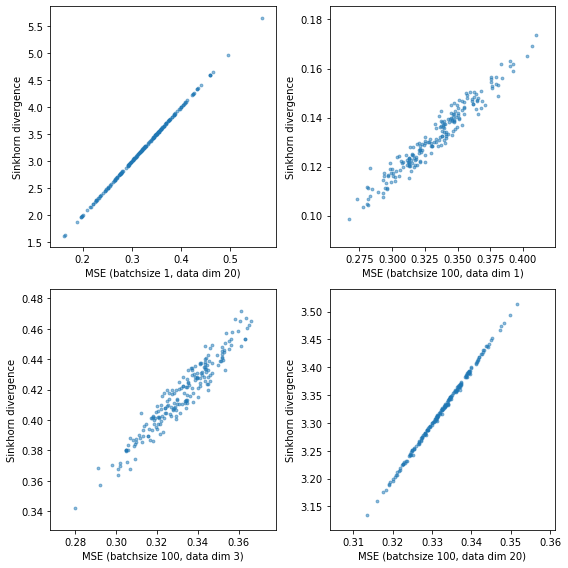

In [43]:
fig = plt.figure(figsize=(8,8))

for panel, (bs, dim, mse, sinkhorn) in enumerate(zip(batchsizes, dims, mses, sinkhorns)):
    ax = plt.subplot(2,2,panel+1)
    plt.scatter(mse, sinkhorn, s=8., alpha=0.5)
    plt.xlabel("MSE (batchsize {}, data dim {})".format(bs, dim))
    plt.ylabel("Sinkhorn divergence")

plt.tight_layout()
plt.show()